In [1]:
import numpy as np
import sys
from os.path import expanduser
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS
import matplotlib
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import warnings
import math
warnings.filterwarnings('ignore')
from IPython.display import Markdown as md
import astropy.units as u
from astropy.cosmology import LambdaCDM
import matplotlib.gridspec as gridspec


### Create the moment maps for Mrk 79 (You have to change some things to work for other cubes)

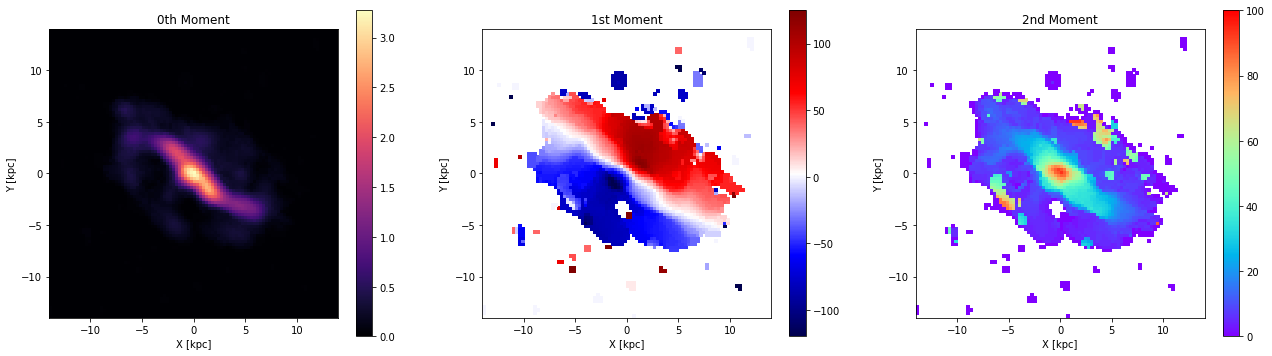

In [2]:
"I will comment with *** the parts you have to change to work for other data cubes"

home = expanduser("~")
datafolder=home+'/Desktop/mrk79/cubes/'  #The folder containing your .fits file
datafolder

mrk79_file='COcube.fits' #.fits file name
mrk79_fits=fits.open(datafolder+mrk79_file)[0]
mrk79_header=mrk79_fits.header
mrk79_data=mrk79_fits.data[0]

dx = np.abs(mrk79_header['CDELT1'])*3600 #arcsec
dy = np.abs(mrk79_header['CDELT2'])*3600 #arcsec
dv = mrk79_header['CDELT3'] #km/s

ydec=np.linspace(-mrk79_data.shape[1]*dy/2. +mrk79_header["CRVAL2"],mrk79_data.shape[1]*dy/2.+mrk79_header["CRVAL2"],mrk79_header['NAXIS2'])
xra=np.linspace(-mrk79_data.shape[2]*dx/2. +mrk79_header["CRVAL1"],mrk79_data.shape[2]*dx/2.+mrk79_header["CRVAL1"],mrk79_header['NAXIS1'])

xx_as=np.linspace(-mrk79_data.shape[2]*dx/2.,mrk79_data.shape[2]*dx/2.,mrk79_header['NAXIS1']) #arcsec
yy_as=np.linspace(-mrk79_data.shape[1]*dx/2.,mrk79_data.shape[1]*dx/2.,mrk79_header['NAXIS2']) #arcsec

b=mrk79_header['CRVAL3']-mrk79_header['CRPIX3']*dv #zero point velocity
vv=np.linspace(b+dv,b+dv*mrk79_header['NAXIS3'],mrk79_header['NAXIS3'])  #velocity channels

sigma=9.3859574E-4 #noise [Jy/beam] # *** change sigma according to your data 
ns=5 # *** change ns to the threshold you want for the Intensity 
                                           
mrk79_mom0 = np.nansum(np.where(mrk79_data>=ns*sigma,mrk79_data,0),axis=0)*np.abs(dv) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)

vv2=np.linspace(0,0,mrk79_header["NAXIS3"]) 
for i in range(mrk79_header['NAXIS3']):
    vv2[i]=np.where(-300<=vv[i] and vv[i]<=300,vv[i],0) # *** choose which velocities you want to keep 
mrk79_mom1=np.nansum(vv2[:,None,None]*np.where(mrk79_data>=ns*sigma,mrk79_data,0),axis=0)/(mrk79_mom0/np.abs(dv)) #first moment

mrk79_mom2=np.sqrt(np.nansum(np.where(mrk79_data>=ns*sigma,mrk79_data,0)*(vv2[:,None,None]-mrk79_mom1)**2,axis=0)/(mrk79_mom0/np.abs(dv)))

cosmo = LambdaCDM(H0=67.8, Om0=0.3,Ode0=0.7) #create a cosmology
z=0.02219  # *** redshift
D=cosmo.luminosity_distance(z) #distance to the object
arctokpc = (cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
ak=arctokpc.value

xx_kpc=xx_as*ak
yy_kpc=yy_as*ak

fig, axes = plt.subplots(1,3,figsize=(22,6))

p0=axes[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0, cmap='magma')
axes[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
axes[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])

p2=axes[2].pcolormesh(xx_kpc,yy_kpc,mrk79_mom2,vmin=0,vmax=100,cmap='rainbow')
axes[2].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='2nd Moment')
fig.colorbar(p2, ax=axes[2])

In [3]:
""" I tried to make a 'user friendly' way to fit the velocity field (1st Moment) leaving free the parameters you want 
    from Françoise's code. I am not sure how she determined the fixed parameters and which parameters she 
    let free, because she just creates the velocity field/orbits in her code, not doing the fit.
    
    In the analytical_models.dat file there is a list with all the parameters. You can change their values. 
    If the parameter is chosen to be fixed, the value next to it is it's fixed value. If the parameter is
    chosen to be free for the fit, the value next to it is it's initial guess.
    
    You have to save analytical_models.dat after every change and keep it in the same folder with this notebook.
    I will explain (or try to) what every parameter of the code is.
  
----------------------------------------------------------------------------------------------------------------------------------
    FIXED PARAMETERS (just choose a value for them in the analytical_models.dat file. Keep name and value separated with ':'
                      Leave space after the separation. e.g. imodel: 2)
----------------------------------------------------------------------------------------------------------------------------------   
        
        npr, npt : Number of radii, azimuths
        nx: the field size in pixels (you have to keep it the same as your moment1 nx)
        ndiv: the gap between two calculated orbits
        mm: number of spiral arms
        ivbulb: 1 if you want bulge, 0 if you don't
        idv2: 0 for no rotation loss, 1 for loss due to dispersion, 2 for an alternative expression 
        imodel: 1 for Shu method, 2 for epicycles 
        istar: ???? I don't know what this is used for (takes 0 or 1). rilr1 and rilr2 are used with it if istar=1
        ikal: For ikal=0 a bar model is used that I don't know. I use ikal=1 for Kalnajs bar
        red2: 1 to use Φ4 harmonic term, otherwise 0
        red3: 1 to use Φ6 harmonic term, otherwise 0
        hzero: scale-height of disk plane

----------------------------------------------------------------------------------------------------------------------------------
    OTHER PARAMETERS (If you want to fit any of them separate name and initial guess in the .dat file with '='  
                      Leave space after the separation. e.g. phibar0= 100 if you want to fit for phibar0 with initial guess=100
                                                             phibar0: 100 if you want to keep it fixed
                      The bounds for the fit are after '|' and written like: a,b . Use -inf and/or inf if you don't want bounds)
----------------------------------------------------------------------------------------------------------------------------------
        
        rd: the main disk radius
        rmax: the maximum radius of the velocity field/orbits
        beta: bar inclination
        pa: position angle
        phi: bar along Ox for phi=0, also convention: phi rotates in the retro sense
        mb: bulge characteristic mass 
        ab: bulge characteristic radius
        mc: nuclear disk characteristic mass
        ac: nuclear disk characteristic radius
        md: main disk characteristic mass
        ad: main disk characteristic radius
        vh: probably dark matter halo velocity (it is small)
        ah: dark matter halo characteristic radius
        qtoom: Toomre parameter. qtoom>1 for a disk to be stable against collapse
        ai: pitch angle of spirals
        omb: pattern speed 
        ff: spiral strength (don't know what is it)
        cs: No idea what this is (it is used for Shu method)
        phibar0: It is qbar from the paper
        rbar: bar radius. Outside of it the potential changes
        lam: λ/ω . Damping factor (takes values between 0 and 1 , I guess)
"""
display()


In [22]:
"""
RUN FROM THIS CELL AGAIN AFTER CHANGES IN THE .dat FILE

Reading initial values, fixed parameters and bounds from the analytical_models.dat file
"""
infile = open('analytical_models.dat', 'r')
#lines = infile.readlines()
#infile.close()
global name_par, fit_par, fix_par
name_par=['npr', 'npt','nx','ndiv',
          'rd','rmax','beta','pa','phi',
          'mb','ab','ivbulb','idv2',
          'mc','ac','md','ad','vh','ah',
          'qtoom','hzero','mm','ai','omb',
          'ff','cs','imodel','istar','ikal',
          'phibar0','rbar','lam','red2','red3',
          'rilr1','rilr2'
         ]
#input_par=dict.fromkeys(name_par,0)
fit_par={}
par_bounds={}
fix_par={}

for line in infile:
    for key in name_par:#input_par.keys():

        if key==line.split(':')[0]:
            par_fixed={key:float(line.split()[1])}
            fix_par.update(par_fixed)  #fixed parameters dictionary
        if key==line.split('=')[0]:
            par_to_fit={key:float(line.split()[1])}
            boun=line.split('|')[1]
            if boun.split(',')[0]=='-inf':
                boundmin=-np.inf
            else: boundmin=float(boun.split(',')[0])
            if boun.split(',')[1]=='inf':
                boundmax=np.inf
            else: boundmax=float(boun.split(',')[1])
            par_bounds.update({key:[boundmin,boundmax]})
            fit_par.update(par_to_fit) #free parameters dictionary
        
boundaries=[[],[]]
for i, key in enumerate(par_bounds.keys()):
    boundaries[0]=np.append(boundaries[0],par_bounds[key][0])
    boundaries[1]=np.append(boundaries[1],par_bounds[key][1])
print('\033[1m'+'You want to fit the parameters:\n'+'\033[0m',fit_par.keys())
initial=list(fit_par.values())
print('\033[1m''\nWith initial guesses:'+'\033[0m\n',fit_par)
print('\033[1m'+'\nAnd bounds:\n'+'\033[0m',par_bounds)
print('\033[1m'+'\nFixed parameters\n'+'\033[0m',fix_par)
#print(boundaries)

You want to fit the parameters:
 dict_keys(['rd', 'beta', 'pa', 'mb', 'ab', 'mc', 'ac', 'md', 'ad', 'vh', 'ah', 'qtoom', 'omb', 'ff', 'cs'])

With initial guesses:
 {'rd': 9.0, 'beta': 24.96, 'pa': 40.6, 'mb': 10.0, 'ab': 0.5, 'mc': 2.0, 'ac': 0.2, 'md': 10.0, 'ad': 4.0, 'vh': 1.0, 'ah': 0.55, 'qtoom': 1.3, 'omb': 16.0, 'ff': 2.8, 'cs': 0.2}

And bounds:
 {'rd': [0.0, 9.0], 'beta': [0.0, 90.0], 'pa': [0.0, 200.0], 'mb': [0.0, inf], 'ab': [0.0, 100.0], 'mc': [0.0, inf], 'ac': [0.0, 10.0], 'md': [0.0, inf], 'ad': [0.0, 10.0], 'vh': [0.0, 100.0], 'ah': [0.0, 10.0], 'qtoom': [1.0, inf], 'omb': [0.0, 50.0], 'ff': [0.0, 5.0], 'cs': [0.0, 3.0]}

Fixed parameters
 {'npr': 90.0, 'npt': 90.0, 'nx': 97.0, 'ndiv': 1.0, 'rmax': 15.0, 'phi': 60.0, 'ivbulb': 1.0, 'idv2': 1.0, 'hzero': 0.1, 'mm': 2.0, 'ai': 10.0, 'imodel': 2.0, 'istar': 0.0, 'ikal': 1.0, 'phibar0': 3000.0, 'rbar': 10.0, 'lam': 0.05, 'red2': 1.0, 'red3': 1.0, 'rilr1': 3.0, 'rilr2': 5.0}


### The cell below is the function that calculates the velocity field and the orbits.
### It returns the model velocity field in order to fit it with moment1

In [23]:

"""
????
UNITS: UM=2.26 10**9 (?), UR= 1 KPC, UV= 1 KM/S                    
G=4.3* 10^(-6) kpc*M_sun*(km/s)^2 , UT=10 MYRS...
????
"""
input_par=dict.fromkeys(name_par,0)
#display(input_par)
def francoise(xy_mesh, *params):
    
    #for i in range(len(params)):
    n=0
    for key in fit_par.keys():
        for key2 in input_par.keys():
            if key==key2:
                while n<=len(params)-1:
                    input_par[key]=params[n]
                    n=n+1
                    break
    for key in fix_par.keys():
        for key2 in input_par.keys():
            if key==key2:
                input_par[key]=fix_par[key]

    #---------------Read all the input parameters---------------------
    cs=input_par['cs']
    ff=input_par['ff']

    ac=input_par['ac']
    ad=input_par['ad']

    mc=input_par['mc']
    md=input_par['md']
    rd=input_par['rd']
    npr=int(input_par['npr'])
    npt=int(input_par['npt'])   
    nx=int(input_par['nx'])
    ndiv=input_par['ndiv']
    ny=nx
    lam=input_par['lam']
    rbar=input_par['rbar']
    phibar0=input_par['phibar0']
    rilr1=input_par['rilr1']
    rilr2=input_par['rilr2']

    red2=input_par['red2']
    red3=input_par['red3']
    
    mm=input_par['mm']
    omb=input_par['omb']
    ab=input_par['ab']
    mb=input_par['mb']
    rmax=input_par['rmax']

    vh=input_par['vh']
    ah=input_par['ah']
    qtoom=input_par['qtoom']
    hzero=input_par['hzero']

    ivbulb=int(input_par['ivbulb'])
    idv2=input_par['idv2']
    imodel=int(input_par['imodel'])
    ikal=int(input_par['ikal'])
    istar=int(input_par['istar'])

    phi=input_par['phi']
    ai=input_par['ai']
    beta=input_par['beta']
    pa=input_par['pa']
    #-------------------------------------------------------------------

    # ------------------- Start of Françoise's code -----------------------------------------------------
    
    phi=np.deg2rad(phi)
    ai=np.deg2rad(ai)
    beta=np.deg2rad(beta)
    xcen=(nx+1.)/2.
    ycen=xcen
     
    """
    difference of convention: Shu phi=0 if bar //Oy
    then you can add p0
    """
    p0=-np.pi/2.
    p0=0.0
    """
    if p0=0, bar along Ox for phi=0
    also convention: phi rotates in the retro sense.....
    """

    factor=np.sin(ai)/mm  
    vunit=1.
    ut=10.
    uv=vunit
    g=4.3e-6
    sq2=np.sqrt(2.)

    soft=0.002**2

    v3=g*mb*(ab**2+rd**2)**(3/2)/rd**3  #M(<rd)=Mbulge*rd^3/(rd^2+ab^2)^(3/2) #v3/g=mb
    vc3=g*mc/(1-(1+rd**2/ac**2)**(-1/2)) # vc3/g=mc
    vd3=g*md/(1-(1+rd**2/ad**2)**(-1/2)) # vd3/g=md

    sv3=np.sqrt(v3) #velocity dispersion
    svd3=np.sqrt(vd3)
    svc3=np.sqrt(vc3)

    SIGzd= vd3/(2*g*np.pi*ad**2) 
    SIGzc= vc3/(2*g*np.pi*ac**2) 
    SIGzb= ivbulb*v3/(g*2*np.pi*ab**2)
    SIGze= SIGzd+SIGzb+SIGzc #sum of surface densities in characteristic lengths of disks + bulge (ac,ad, ab)

    # to add bulge: ivbulb=1 , else ivbulb=0

    aniso=1. #????
    rmin=0
    dr=(rmax-rmin)/(npr-1)
    dt=2*np.pi/(npt-1)
    dx=2*rmax/(nx)
    dy=dx

    """
    =====================================
      Loop on bar orientations!
    =====================================
    
    ---------------------------------------------------------------------------
     radial loop
    ---------------------------------------------------------------------------
    """
    iorb=0
    ipoint=0
    P2max=-1e8

    sigma=rad=vdisk=vbul=vdark=sigz=sigr=sigt=vrot=ome=cap=omm=omp=xspi=yspi=xspi2=yspi2=np.linspace(0,0,npr)
    xorb=yorb=vpol=disp2=vzer=np.zeros(shape=(npr,npt))
    vcir=vper=vtot=sigv2=np.zeros(shape=(nx,ny))
    for ir in range(1,npr): 

        iorb=iorb+1
        rad[ir]=rmin+(ir-0.5)*dr
        rr=rad[ir]
        rt=np.sqrt(rr**2+soft)
        amu=SIGzd*(1+rr**2/ad**2)**(-3/2)
        amu=amu+SIGzc*(1+rr**2/ac**2)**(-3/2) #main disk-nuclear disk surface density
        
    #   add bulge?
        amu=amu+ivbulb*v3/g/(2.*np.pi*ab**2*(1.+ rr**2/ab**2)**(3/2)) #add the bulge surface density
   
    #   angular velocity for main disk
        omeg=svd3*(rr**2+ad**2+soft)**(-3/4) #Ω=sqrt((1/R) *dΦο/dR)
        vdisk[ir]=omeg*rr*uv
        capa2=4.*(ad**2+.25*rr**2)/(ad**2+rr**2)*omeg**2 #for the k^2 formula: https://en.wikipedia.org/wiki/Epicyclic_frequency

    #    and nuclear disk
        omegc=svc3*(rr**2+ac**2+soft)**(-3/4)
        omeg=np.sqrt(omeg**2+omegc**2)     
        
    #   and spheroide (bulge)...
        omeg3=sv3*(rr**2+ab**2+soft)**(-3/4)
        vbul[ir]=rr*omeg3*uv
        omeg=np.sqrt(omeg**2+omeg3**2)
        
    #   and spheroide (halo-dark matter)...
        omeg3h=vh*sq2/(rr**2+ah**2+soft)**(1/2)
        vdark[ir]=rr*omeg3h*uv
        omeg=np.sqrt(omeg**2+omeg3h**2) 

        capa2b=4.*(ab**2+0.25*rr**2)/(ab**2+rr**2)*omeg3**2 #k^2 of bulge (not sure if the formula is right)
        capa2=capa2b+capa2
        capa2c=4.*(ac**2+0.25*rr**2)/(ac**2+rr**2)*omegc**2 #k^2 of nuclear disk
        capa2=capa2c+capa2
        capa2h=2.*(2.*ah**2+rr**2)/(ah**2+rr**2)*omeg3h**2 #k^2 of dark matter halo
        capa2=capa2h+capa2 #k^2 total
        capa=np.sqrt(capa2)
        
        DOME2= -3.*vd3*rr**2*(ad**2+rt**2)**(-2.5)                   #R*d(Ω^2)/dR = -(1/R)dΦ/dR + d^2(Φ)/dR^2            
        DOME2 = DOME2 -3.*vc3*rr**2*(ac**2+rt**2)**(-2.5)
        DOME2 = DOME2 -3.*v3*rr**2*(ab**2+rt**2)**(-2.5)
        DOME2 = DOME2 -4.*vh**2*rr**2*(ah**2+rt**2)**(-2)
    # !!  d(ome2)/dr*rr in fact

    # calcul of dispersion, + asymmetric drift
        dcap2dr=4.*DOME2/rr - 3.*vd3*rr*((ad**2+rt**2)**(-5/2))*(2.-5.*rr**2/(ad**2+rt**2))-\
                              3.*vc3*rr*((ac**2+rt**2)**(-5/2))*(2.-5.*rr**2/(ac**2+rt**2))-\
                              3.*v3*rr*((ab**2+rt**2)**(-5/2))*(2.-5.*rr**2/(ab**2+rt**2))-\
                              8.*vh**2*rr*(ah**2+rt**2)**(-2)*(1.-2*rr**2/(ah**2+rt**2))
    # is in fact dcap2/dr

        SIGMAr=vd3/g/(2.*np.pi*ad**2*(1.+ rr**2/ad**2)**(1.5))                       

        SIGMAr=SIGMAr+vc3/g/(2.*np.pi*ac**2*(1.+ rr**2/ac**2)**(1.5))                       

        SIGMAr=SIGMAr+ivbulb*v3/g/(2.*np.pi*ab**2*(1.+ rr**2/ab**2)**(1.5)) 

        #qtoomr=qtoom/np.exp(1.2*rr**2/rd**2)   #qtoom as a function of rr                                  
        qtoomr=qtoom #constant
        dmudr=-3.*rr/ad**2*(1+rr**2/ad**2)**(-2.5)*SIGzd/SIGze

        dmudr=dmudr-3.*rr/ac**2*(1+rr**2/ac**2)**(-2.5)*SIGzc/SIGze

        dmudr=dmudr-3.*rr/ab**2*(1+rr**2/ab**2)**(-2.5)*SIGzb/SIGze
    #   add bulge?

        if capa>=1e-5:      
            vcrit=(3.36*g*SIGMAr*qtoomr)/capa          # Toomre stability critical velocity                
            vtet=(capa/2./omeg)*vcrit/aniso            

        else:       
            vcrit=0.     
            vtet=0.                     

    #   calcul of loss of rotation, due to dispersion, dv2r is negative

        dv2r=rr/SIGMAr*SIGze*(3.36*g*qtoomr)**2*(3.*SIGMAr**2*dmudr/capa2-SIGMAr**3/SIGze*dcap2dr/capa2**2)+vcrit**2-vtet**2  

        ome2=vd3*(rr**2+ad**2+soft)**(-1.5)
        capad2=4.*(ad**2+.25*rr**2+soft)/(ad**2+rr**2+soft)*ome2
        znu2=2*np.pi*g*SIGMAr/hzero 
        znu2=max(znu2,0.)
        sigz2=hzero**2*znu2
        sigz[ir]=uv*np.sqrt(sigz2)
        sigr[ir]=uv*vcrit
        sigt[ir]=uv*vtet

        if idv2==0: #no rotation loss
            dv2r=0


        if idv2==2:
    # autre expression de dv2= (BT87)
            dlogmu=-3.*rr**2/ad**2/(1+rr**2/ad**2)*SIGzd/SIGze
            dlogmu=dlogmu -3.*rr**2/ac**2/(1+rr**2/ac**2)*SIGzc/SIGze
            dv2r=-vtet**2 +1.5*vcrit**2 -0.5*sigz2 +2.*dlogmu*vcrit**2 +0.5*(vcrit**2-sigz2)
        dv2r=min(dv2r,0.)
        vreal2=omeg**2*rr**2+dv2r
        vreal=np.sqrt(np.abs(vreal2))

    # end dispersions

        vrot[ir]=rr*omeg*uv #rotation curve
        ome[ir]=omeg*uv
        cap[ir]=capa*uv
        omm[ir]=ome[ir]-cap[ir]/2.  #ILR
        omp[ir]=ome[ir]+cap[ir]/2.  #OLR
        tiny=1e-6
        
        #imodel2:epicycles
        
        if imodel==2: 
            pom=2.*(omeg-omb)
            if abs(pom)<tiny: pom=np.sign(pom)*tiny 
                
    #------------------------------------
    # simple models of bars
            if ikal==0:
                cphi=phibar0/rbar**3
                phibar=phibar0/rbar**2
                if rr<rbar:
                    phibar=rr*phibar0*(rbar**2-rr**2)**(1.5) 
                    cphi=-3*rr**2*phibar/(rbar**2-rr**2) +phibar/rr
            else:
        #   Bar of Kalnajs................................ (Emsellem et al.)
                cphi=0.
                phibar=0.
                XBAR=rr**2/rbar**2
                
                BLABLA=1.06*phibar0/(rr**2*rbar**2)
                if rr<rbar:
                    POTRED=(1.-2.5*XBAR+2.1875*XBAR**2-0.65625*XBAR**3)
                    phibar=+0.5*BLABLA*POTRED*rr**4
                    DPHIR=+BLABLA*rr**2*(1.-5.*XBAR+6.5625*XBAR**2-2.625*XBAR**3)
                    cphi=DPHIR*rr
                else:
        #        COMPLETION OF EXTERNAL BAR....
                    BLUB=-0.0641509433962264147*BLABLA/XBAR**3
                    DPHIR=BLUB*rr**2
                    cphi=DPHIR*rr
                    phibar=-BLUB*rr**4/4.

        # end choice Kalnajs
        #---------------------------------------------
            dphi=2.*phibar/np.sqrt(rr**2+soft)


        #  this is the  tang max force
            alam=lam*omeg
        
            P2=dphi/omeg**2/rr
            P2max=max(P2max,P2)
        
        #Calculating a, b, ψ_a, ψ_b for Φ2 Φ4 and Φ6
        #   harm 1
            Aort=(4.*omeg**2-capa2)/4./omeg
            denom=np.sqrt((capa2-pom**2)**2+16.*pom**2*alam**2)
            blib=pom*cphi+2.*omeg*dphi
            aep= blib/pom/denom   
            bep=(dphi-2*omeg*pom*aep)/pom**2

            defas=math.atan2(-2.*pom*alam, capa2-pom**2)
            defasb=math.atan2(dphi-2*omeg*pom*aep*np.cos(defas), 2*omeg*pom*aep*np.sin(defas))
            
        #   harm 2 (red2)
            harm=2
            denom=np.sqrt((capa2-harm**2*pom**2)**2+16.*harm**2*pom**2*alam**2)
            aep2=red2*(harm*pom*cphi+2.*omeg*dphi)/harm/pom/denom
            bep2=(dphi-2*omeg*harm*pom*aep2)/pom**2/harm**2
            defas2=math.atan2(-4.*harm*pom*alam, capa2-harm**2*pom**2)
            defasb2=math.atan2(dphi-2*omeg*harm*pom*aep*np.cos(defas2), 2*omeg*harm*pom*aep*np.sin(defas2))

        #   harm 3 (red3)------------------------------
            harm=3
            denom=np.sqrt( (capa2-harm**2*pom**2)**2+ 16.*harm**2*pom**2*alam**2)
            aep3= red3*(harm*pom*cphi+ 2.*omeg*dphi)/harm/pom/denom
            bep3=(dphi-2*omeg*harm*pom*aep3)/pom**2/harm**2
            defas3=math.atan2(-4.*harm*pom*alam,capa2-harm**2*pom**2)
            defasb3=math.atan2(dphi-2*omeg*harm*pom*aep*np.cos(defas3), 2*omeg*harm*pom*aep*np.sin(defas3))

            if istar==1: #???? I don't know what this if statement is ????
                defas=0
                if rr>rilr1 and rr<=rilr2: defas=np.pi
                defas2=defas
                defas3=defas


            if iorb>=ndiv: #separation between orbits calculated
                iorb=0
                ipoint=ipoint+1



    #  end imodel=2

    #  imodel =1, Shu          

        ka=-mm*np.cos(ai)/np.sin(ai)/rr  # ???? I don't know what the Shu method is supposed to do
        gu=factor*rr*omeg                # I run the code with imodel=2 (epicycles)
        gv=factor*rr*capa2/2./omeg
        anu=mm*(omb-omeg)/capa
        ax=cs**2/2./gu/gv
        bet=1./(1.-anu**2+ax)
        alpha=anu*bet
        """
        --------------------------------------------------
                    azimuthal loop
        --------------------------------------------------
        """
        ipot=0
        iteta=0
        for it in range(1,npt):
            ipot=ipot+1
            teta=it*dt #time
            #if imodel=1 : Shu
            eta=np.pi-ka*rr*np.log(rr)+mm*(teta+phi)
    # the minimum of potential is eta=0 (ki=pi)
            teta1=(ka*rr*np.log(rr)-np.pi)/mm -phi 
            xspi[ir]=rr*np.cos(teta1)
            yspi[ir]=rr*np.sin(teta1)*np.cos(beta)
            veta=ff*np.sqrt(2.*gu*gv)*alpha*np.cos(eta)
            vxi=ff*gv*bet*np.sin(eta)
    # rotation of pitch angle, to pass in (rr,teta)
            vrr=np.cos(ai)*veta-np.sin(ai)*vxi
            vteta=np.sin(ai)*veta+np.cos(ai)*vxi

            if imodel==2:
    # choice epicycle
                ptet=teta+phi+p0
                #solution for ξ_dot , η_dot from Emsellem paper
                vrr=-aep*pom*np.sin(2.*(ptet)+defas) - aep2*2*pom*np.sin(4.*(ptet)+defas2) - aep3*3*pom*np.sin(6.*(ptet)+defas3) 
                vteta=(bep*pom+2.*Aort*aep)*np.sin(2.*(ptet)+defasb) +\
                      (bep2*2*pom+2.*Aort*aep2)*np.sin(4.*(ptet)+defasb2) +\
                      (bep3*3*pom+2.*Aort*aep3)*np.sin(6.*(ptet)+defasb3)  
                if ipot>=1:
                    ipot=0
                    iteta=iteta+1
                    #solution for ξ,η 
                    radi=rr+aep*np.cos(2.*(ptet)+defas) + aep2*np.cos(4.*(ptet)+defas2) + aep3*np.cos(6.*(ptet)+defas3)
                    tetai=teta+bep*np.cos(2.*(ptet)+defasb) + bep2*np.cos(4.*(ptet)+defasb2) + bep3*np.cos(6.*(ptet)+defasb3)
                    #orbit 
                    xorb[ipoint,iteta]=radi*np.cos(tetai)
                    yorb[ipoint,iteta]=radi*np.sin(tetai)
    # end imodel=2 (epicycles)

    #  suppose line of  nodes horiz
            vpol[ir,it]=(vrr*np.sin(teta)+vteta*np.cos(teta))*uv*np.sin(beta)

    # calcul of dispersions  projected
            disp2[ir,it]=(sigz2*np.cos(beta)**2+np.sin(beta)**2*(vcrit**2*np.sin(teta)**2 + vtet**2*np.cos(teta)**2))*uv**2

    # same for velocities at zero order ..
            vrr   =0.
            vteta=vreal

            #vteta=rr*(omeg-omb) to be in the rotating  reference frame

            vzer[ir,it]=(vrr*np.sin(teta)+vteta*np.cos(teta))*uv*np.sin(beta)
        # -------- end azimuthal loop ---------------------------------
        
    # --------------------------  end radial loop ---------------------------------------------

    
    # ----------------- Deproject from (ξ,η) coordinates to (X,Y) ---------------------------------
    for ix in range(1,nx):
        for iy in range(1,ny): 
            xx=(ix-xcen)*dx   
            yy=(iy-ycen)*dy/np.cos(beta)

            r=np.sqrt(xx**2+yy**2)

            if r>=rmax:
                vcir[ix,iy]=0. #circular velocity
                vper[ix,iy]=0. #perturbation
                sigv2[ix,iy]=0.
            else:
                if rr!=0.:
                     teta=math.atan2(yy,xx) #θ angle of polar coordinates
                else:
                     teta=-np.pi/2

                if teta<=0.: teta=teta+2*np.pi

                ir=r/dr+1 #the point that is being followed is in this distance (in pixels)
                ir1=ir+1  #this is the next pixel
                
                it=teta/dt+1 #pixel of θ 
                it1=it+1
                
                xr=1.+r/dr-ir
                xt=1.+teta/dt-it
                xrm=1.-xr
                xtm=1.-xt
                if it1>npt: it1=it1-npt
                if ir1>npr: ir1=npr
                ir=int(ir)
                ir1=int(ir1)-1
                it=int(it)-1
                it1=int(it1)
                vcir[ix,iy]=vzer[ir,it]*xrm*xtm+vzer[ir1,it]*xr*xtm \
                           +vzer[ir,it1]*xrm*xt+vzer[ir1,it1]*xr*xt

                vper[ix,iy]=vpol[ir,it]*xrm*xtm+vpol[ir1,it]*xr*xtm \
                           +vpol[ir,it1]*xrm*xt+vpol[ir1,it1]*xr*xt

                sigv2[ix,iy]=disp2[ir,it]*xrm*xtm \
                            +disp2[ir1,it]*xr*xtm \
                            +disp2[ir,it1]*xrm*xt+disp2[ir1,it1]*xr*xt

    for ix in range(1,nx): 
        for iy in range(1,ny): 
            vtot[ix,iy]=vcir[ix,iy]+vper[ix,iy] # Vtotal with line of nodes  horizontally, taking into account  beta=incl...
    # d or ang=pa-pi/2.
    """
    IGNORE------------------------
    #     ombv=omb*uv
    #     # search R corotation
    #     blav=ome[1]-ombv
    #     for ir in range(1,npr): 
    #         bla=ome[ir]-ombv
    #         prod=blav*bla
    #         if prod<=0.: break
    #         blav=bla     

    #     rcor=rad[ir]
    IGNORE------------------------
    """ 
#-------------------------------------------------------------------------------------------

# ------------------ Deproject for PA ---------------------------
    vfin=np.zeros(shape=(nx,ny))
    pa=np.deg2rad(pa)
    #ROTATION
    for i in range(1,nx): 
        for j in range(1,ny): 
            x=(i-xcen)*np.cos(beta)
            y=(j-ycen)*np.sin(beta)
            xpr=x*np.cos(pa)+y*np.sin(pa)     #}Deproject the pixel number
            ypr=(-x*np.sin(pa)+y*np.cos(pa))  #}for pa with Rotation matrix R(-θ)
            ip=int(xpr+xcen)-1
            jp=int(ypr+ycen)
            ip1=int(ip+1)
            jp1=int(jp+1)
            if(ip<1 or ip1>nx): break
            if(jp<1 or jp1>ny): break
            xx1=xpr+xcen-ip
            yy1=ypr+ycen-jp
            p1=(1.-xx1)*(1.-yy1)  #Not sure what          ????
            p2=xx1*(1.-yy1)       # p1, p2, p3, p4 are.   ????
            p3=(1.-xx1)*yy1       #                       ????
            p4=xx1*yy1            #                       ????
            
            #final velocity field deprojected for pa
            vfin[i,j]=vtot[int(ip),int(jp)]*p1+vtot[int(ip1),int(jp)]*p2 +\
                      vtot[int(ip),int(jp1)-1]*p3+vtot[int(ip1),int(jp1)-1]*p4
# ------- End of Françoise's code -------------------------------------------------------


    vfin=np.where(np.isnan(mrk79_mom1),0,vfin) # I did this to put 0's in the model where moment1 from data is nan, 
                                               # otherwise we will get a model with values in regions we have no data
    
    return np.ravel(vfin) # I return the 2-D model velocity as a 1-D array
                          # in order to use scipy.optimize.curve_fit with the moment1 from data 
                          # which is also turned in a 1-D array


In [24]:
%%time
"""
DO THE FIT
"""
xy_mesh=np.meshgrid(xx_kpc,yy_kpc)
ydata=np.where(np.isnan(mrk79_mom1),0,mrk79_mom1).ravel() #moment1 in 1-D array

franc_p=curve_fit(francoise, xy_mesh, ydata, p0=initial,bounds=boundaries)
calc_par=dict.fromkeys(fit_par,0)
for i, key in enumerate(calc_par.keys()): calc_par[key]=franc_p[0][i]
print('\n\033[1m'+'Calculated values of parameters after fit'+'\033[0m')
for key in calc_par.keys(): print('\n\033[1m'+key+'\033[0m',':', round(calc_par[key],3))


Calculated values of parameters after fit

rd : 9.0

beta : 38.196

pa : 39.507

mb : 15.906

ab : 0.314

mc : 2.563

ac : 0.181

md : 10.889

ad : 1.912

vh : 42.878

ah : 0.26

qtoom : 1.3

omb : 16.0

ff : 2.8

cs : 0.2
CPU times: user 5min 34s, sys: 160 ms, total: 5min 34s
Wall time: 5min 34s


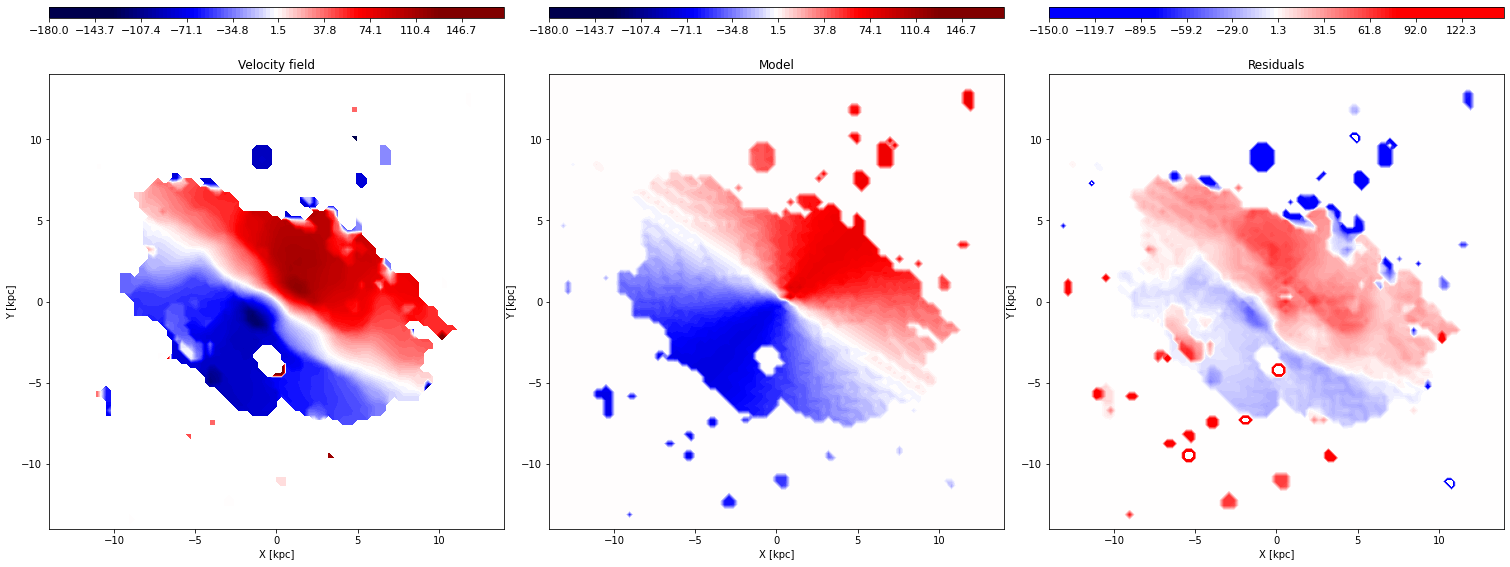

In [25]:
"""
Plot 1st moment , Model and Residuals

The fit is not good, because I left too many parameters free. I have to set some fixed but I don't know to what values.
"""
model_image=francoise(xy_mesh, *franc_p[0]).reshape(len(xx_kpc),len(yy_kpc))
residuals=ydata.reshape(len(xx_kpc),len(yy_kpc))-model_image
fig = plt.figure(figsize=(20,16))
gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ax0 = fig.add_subplot(gs[1,0])
cax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,1])
cax1 = fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[1,2])
cax2=fig.add_subplot(gs[0,2])

c0=ax0.contourf(xx_kpc,yy_kpc,mrk79_mom1,vmin=-130,vmax=130,levels=np.linspace(-180,180,120),cmap='seismic')
plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=11)
ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
#ax0.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
#ax0.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c1=ax1.contourf(xx_kpc,yy_kpc,model_image,cmap='seismic',vmin=-130,vmax=130,levels=np.linspace(-180,180,120))
plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=11)  
ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Model')   
#ax1.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
#ax1.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c2=ax2.contourf(xx_kpc,yy_kpc,residuals,vmin=-80,vmax=80 ,cmap='bwr',levels=np.linspace(-150,150,120))
plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=11)
ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Residuals')   
#ax2.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
#ax2.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
plt.show()
